In [14]:
PRFX_ESMB = 'MelInfEsmb0729A1'

In [15]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
import matplotlib.pyplot as plt

class Param: pass

p_esmb = f'../output/{PRFX_ESMB}'; Path(p_esmb).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'

In [16]:
prfx2wgt = {
    'MelInf0726B2tta16': 1,
    'MelInf0727A1tta16': 1,
    'MelInf0727B1tta16': 1,
    'MelInf0726G2tta16': 1,
    'MelInf0726H2tta16': 1,
}

In [17]:
prfx2oofs = {}
for prfx in prfx2wgt.keys():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof.mean(1)
        oofs += list(oof)

    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)

    oofs = np.array(oofs)
    prfx2oofs[prfx] = oofs
    
    scr = roc_auc(ys, oofs)
    print(prfx, param.ARCH, param.SZ, f'{scr:.4f}', end=' ')
    
    idx20 = np.where(dftrn.source==20)[0]
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs[idx20])
    print(f'{scr20:.4f}')

MelInf0726B2tta16 efficientnet-b0 224 0.9279 0.8960
MelInf0727A1tta16 efficientnet-b3 224 0.9294 0.9063
MelInf0727B1tta16 efficientnet-b4 224 0.9318 0.9094
MelInf0726G2tta16 efficientnet-b5 224 0.9288 0.9113
MelInf0726H2tta16 efficientnet-b6 224 0.9317 0.9139


In [18]:
oofs_esmb= np.zeros(len(dftrn))
for prfx,wgt in prfx2wgt.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    oofs_esmb += wgt*prfx2oofs[prfx]
    scr = roc_auc(ys, oofs_esmb)
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs_esmb[idx20])
print(PRFX_ESMB, f'{scr:.4f}', f'{scr20:.4f}')

MelInfEsmb0729A1 0.9364 0.9167


MelInf0726B2tta16 0.17577293900882407


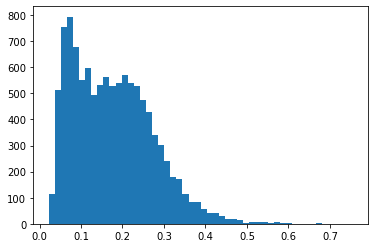

MelInf0727A1tta16 0.15930823437581493


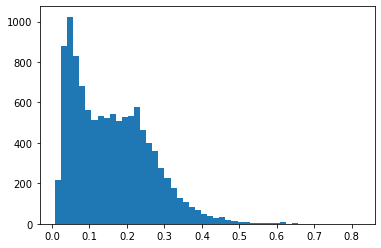

MelInf0727B1tta16 0.15253438272176548


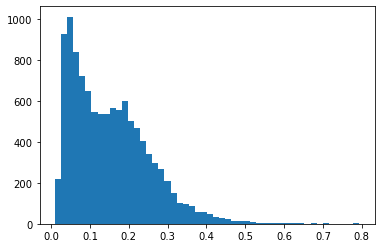

MelInf0726G2tta16 0.15595904496625135


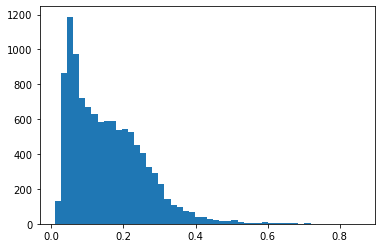

MelInf0726H2tta16 0.15230585584603645


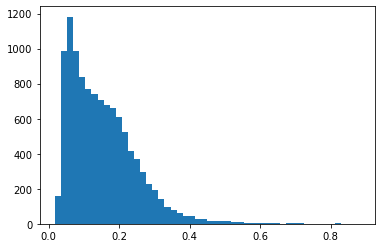

In [19]:
dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv') 


wgt_ttl=0
sub_esmb=np.zeros(len(dfsub))
for prfx,wgt in prfx2wgt.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    dfsubi = pd.read_csv(f'{p_out}/submission_{prfx}_avglast{param.LASTM}.csv')
    wgt_ttl+=wgt
    subi = dfsubi.target
    print(prfx, subi.mean())
    plt.hist(subi, bins=50);
    plt.show()
    sub_esmb+=subi
sub_esmb/=wgt_ttl

0.15917609138373748


,image_name,target
0,ISIC_0052060,0.042949
1,ISIC_0052349,0.043236
2,ISIC_0058510,0.070104


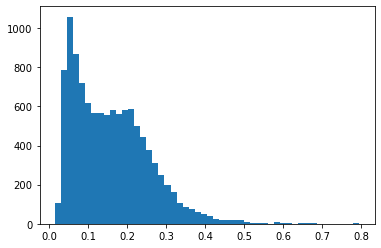

In [20]:
print(sub_esmb.mean())
dfsub.target = sub_esmb

display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [21]:
dfsub.to_csv(f'{p_esmb}/submission_{PRFX_ESMB}.csv', index=False)